#**CIS 419/519**

## Boosting and Stacking worksheet 

In this notebook, two examples for ensemble methods are provided. 

In the first example, you will use `GradientBoostingRegressor` in `sklearn` to generate a model from an ensemble of weak predictive models. More details on this function can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor). In the second example, you will explore the usage of `StackingClassifier` in `sklearn` to stack a few base learners, combine it with a meta learner to get a predictive model. More info on the function `StackingClassifier` can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html).

Note that more resources on ensemble methods are given at the end of this worksheet.

# Gradient Boosting for Regression

### **Quick Aside: Decision Tree Regressors**

At the beginning of this course, we learned how to use decision trees for classification. These trees used measures like entropy (and corresponding information gain) to try to maximize the homogeneity of classes in each split. It turns out, we can also use decision trees for regression. Instead of splitting based on information gain, these trees split in a way that minimizes one of various residual-based meaures (commonly the mean-squared error). That is, we minimize the sum of squared differences between the actual target values and the predictions at each node, which are made of an average of the target values in that node. For a more detailed explanation of how this works, you can refer to [this article.](https://medium.com/analytics-vidhya/regression-trees-decision-tree-for-regression-machine-learning-e4d7525d8047)

This is important to note because Gradient Boosting, whether used for regression or classification, uses decision tree regressors as its weak learner rather than decision tree classifiers. **Why do you think this is?**


### **Back to Gradient Boosting Regressors**

Gradient boosting Regression calculates the difference between the current prediction and the known correct target value; this difference is called a residual. Gradient boosting Regression then trains a weak model that maps features to that residual. This residual predicted by a weak model is added to the existing model input and thus this process nudges the model towards the correct target. Repeating this step again and again improves the overall model prediction.

---
# Gradient Boosting regression Example - Predicting Diabetes Progression

This example demonstrates Gradient Boosting to produce a predictive model from an ensemble of weak predictive models. Gradient boosting can be used for regression and classification problems (for more detail on that, look [here](https://towardsdatascience.com/gradient-boosted-trees-for-classification-one-of-the-best-machine-learning-algorithms-35245dab03f2)). 

Here, you will train a model to tackle a diabetes regression task. Results from GradientBoostingRegressor with least squares loss and 500 regression trees of depth 4 are obtained. This example is adapted from [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py).

We will be using the familiar Diabetes dataset, which tries to predict a quantitative measure of diabetes progression based off a variety of factors.

Let's import the required packages first.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

### Data loading
Next, we need to load the data, and split it into train and test sets.

In [ ]:
diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target

In [ ]:
pd.DataFrame(y).describe()

,0
count,442.000000
mean,152.133484
std,77.093005
min,25.000000
25%,87.000000
50%,140.500000
75%,211.500000
max,346.000000


In [ ]:
# Split the data, with 90% for training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13)


###Fit regression model

Now we will initiate the gradient boosting regressors and fit it with our training data. We'll also look and the mean squared error on the test data.

To create our model, we will use the GradientBoostingRegressor object from the sklearn.ensemble. Let's go over some (but not all) of the important parameters. You can vary these parameters to see how the results change.

*n_estimators*: the number of boosting stages that will be performed. Later, we will plot deviance against boosting iterations.

*max_depth*: limits the number of nodes in the tree. The best value depends on the interaction of the input variables.

*min_samples_split*: the minimum number of samples required to split an internal node.

*learning_rate*: how much the contribution of each tree will shrink.

*loss*: loss function to optimize. The least squares function is used in this case..

In [ ]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score

num_estimators = 500
reg = ensemble.GradientBoostingRegressor(n_estimators = num_estimators,
          max_depth = 4,
          min_samples_split = 5,
          learning_rate = 0.01,
          loss = 'ls',
          random_state= 42)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 3022.4340


###Plot our performance
Finally, we will visualize the results. To do that we will compute the training set and testing set deviance (loss on the in-bag sample, which in our case is the whole training/testing set since we are not using bagging) and then plot it against boosting iterations (n_estimators).

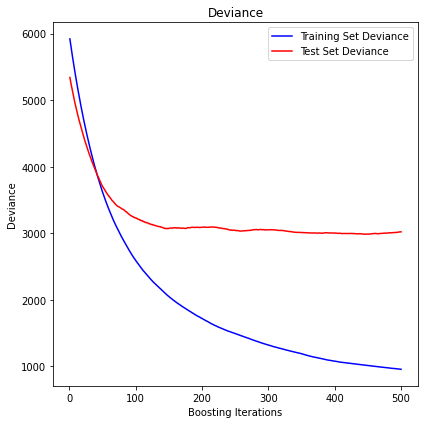

In [ ]:
# Start our plot with the training deviance
fig = plt.figure(figsize=(6, 6))
plt.title('Deviance')

# .train_score_ gives us the training deviance at each boosting iteration
plt.plot(np.arange(num_estimators) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')

# Now let's add the plot of test deviance

# We don't have an attribute for the test score like we did train_score_, so we have to make our own
test_score = np.zeros((num_estimators,), dtype=np.float64)
# use the staged_predict method of our GradientBoostingRegressor here to 
# test how our model performs at each stage of our X, according to the number of estimators used
for i, y_pred in enumerate(reg.staged_predict(X_test)):
  # Get our test loss (mean-squared error) at each stage
    test_score[i] = reg.loss_(y_test, y_pred)

plt.plot(np.arange(num_estimators) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

**What does this graph tell us?**

---
#Example 2 - Stacking with `sklearn`

Stacking is a technique that takes several regression or classification models and uses their output as the input for the meta-classifier/regressor. In other words, stacking is an ensemble learning technique where the quality of prediction is improved by combining, typically, weak models. Where boosting and bagging typically use homogenous models, stacking typically uses heterogenous models, performing best when those models all have different strengths and weaknesses (and their errors are relatively uncorrelated).

This example demonstrates how you can use `StackingClassifier` in `sklearn` to simplify stacking pipelines and create useful models. This is adapted from [here](https://towardsdatascience.com/stacking-made-easy-with-sklearn-e27a0793c92b). 

---
The first model that we are going to implement is a classifier that predicts a flower's species (the familiar iris dataset). We use a Random Forest and k-Nearest Neighbors as our base learners and a Logistic Regression as our meta learner (see image below). 

![picture](https://drive.google.com/uc?export=view&id=1CHHGB1RSZ1vAAwARq0dBbmJI2B5fUNoy) 
[Image source](https://towardsdatascience.com/stacking-made-easy-with-sklearn-e27a0793c92b).

Coding stacking models can be quite tricky as you will have to take into account the folds that you want to generate and cross-validation at different steps. Fortunately, `sklearn` makes it possible to create the model shown above in just a few lines of code.


In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X, y = load_iris(return_X_y=True)

# Create Base Learners
# Note the estimators parameter takes a list of tuples in the form of (str, estimator)
base_learners = [
                 ('rf_1', RandomForestClassifier(n_estimators=10, random_state=42)),
                 ('knn_1', KNeighborsClassifier(n_neighbors=5))             
                ]

# Initialize Stacking Classifier with the Meta Learner

# Estimators are fitted on the full X while final_estimator is trained using 
# cross-validated predictions of the base estimators using cross_val_predict.
# In most cases (see documentation), when the cv parameter is None (default) it
# is actually using 5-fold cross validation. But you can customize your cv strategy!

clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

# Extract score
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
clf.fit(X_train, y_train).score(X_test, y_test)

0.9473684210526315

In an attempt to improve accuracy, we can add another layer of learners to the previous model, as illustrated in this image:


![picture](https://drive.google.com/uc?export=view&id=1nAMyUg8o918Y4w5AR0ckGx3s1jNDCi97) 
[Image source](https://towardsdatascience.com/stacking-made-easy-with-sklearn-e27a0793c92b).

As shown above, we add a layer that includes two additional classifiers, namely a Decision Tree and a Random Forest. However, the `StackingClassifier` only has parameters for two layers- the base estimators and the meta estimator that will use the predictions from the base estimators. Knowing this, **how would we go about adding more layers?**

(Try thinking about this before moving on)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

The answer is, we create two lists of estimators, one for each layer. Next, a `StackingClassifier` is created using the second layer of estimators with the final model, namely the Logistic Regression. Then, we create another `StackingClassifier` by combining the previously mentioned `StackingClassifier` with the first layer of estimators to create the full pipeline of models.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = load_iris(return_X_y=True)

# Create Learners per layer
layer_one_estimators = [
                        ('rf_1', RandomForestClassifier(n_estimators=10, random_state=42)),
                        ('knn_1', KNeighborsClassifier(n_neighbors=5))             
                       ]
layer_two_estimators = [
                        ('dt_2', DecisionTreeClassifier()),
                        ('rf_2', RandomForestClassifier(n_estimators=50, random_state=42)),
                       ]
layer_two = StackingClassifier(estimators=layer_two_estimators, final_estimator=LogisticRegression())

# Create Final model by 
clf = StackingClassifier(estimators=layer_one_estimators, final_estimator=layer_two)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
clf.fit(X_train, y_train).score(X_test, y_test)

0.9736842105263158

###More resources on ensemble methods (boosting, bagging, stacking):
- https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de
- https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
- https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205
- https://blog.statsbot.co/ensemble-learning-d1dcd548e936